# Transfer Learning using EfficientNetB0
- In this notebook, I have used **Transfer Learning** to classify images of **Cat, Kanye West and Pickachu** using pre-trained ImageNet model **EfficientNetB0**.
- The image data used in this notebook has been scrapped from the internet. Each class contains more than 1000 images.

# Part 1

## Import Section

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import (load_img, img_to_array, 
                                                  ImageDataGenerator)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read and prepare data

In [13]:
MAIN_DIR = '/content/drive/MyDrive/Cat Pikachu Kanye'

CAT_DIR = MAIN_DIR + '/Cats'           # cat images directory
KW_DIR = MAIN_DIR + '/KWest'           # Kanye West images directory
PIKACHU_DIR = MAIN_DIR + '/Pikachu'    # pikachu images directory

# define some global variables
BATCH_SIZE = 32
SEED = 42
IMG_SIZE = (224, 224)
LABELS = ['cat', 'kanye', 'pikachu']

### Read Cat images

In [4]:
images_data = []   # to store images
image_labels = []   # to store labels

# read and prepare images and labels 
for file_name in tqdm(os.listdir(CAT_DIR)):
  try:
    # load and resize images
    image = load_img(os.path.join(CAT_DIR, file_name), 
                     target_size = IMG_SIZE)
    # convert image into array
    images_data.append(img_to_array(image))
    # prepare labels 
    image_labels.append(0)
  except:
    print(f'{file_name} image file is empty')

100%|██████████| 1598/1598 [13:02<00:00,  2.04it/s]


### Read Kanye West images

In [5]:
for file_name in tqdm(os.listdir(KW_DIR)):
  try:
    # load and resize images
    image = load_img(os.path.join(KW_DIR, file_name), target_size = IMG_SIZE)
    # convert image into array
    images_data.append(img_to_array(image))
    # prepare labels 
    image_labels.append(1)
  except:
    print(f'{file_name} image file is empty')

100%|██████████| 1063/1063 [09:46<00:00,  1.81it/s]


### Read Pikachu images

In [6]:
for file_name in tqdm(os.listdir(PIKACHU_DIR)):
  try:
    # load and resize images
    image = load_img(os.path.join(PIKACHU_DIR, file_name), target_size = IMG_SIZE)
    # convert image into array
    images_data.append(img_to_array(image))
    # prepare labels 
    image_labels.append(2)
  except:
    print(f'{file_name} image file is empty')

  2%|▏         | 27/1191 [00:17<12:06,  1.60it/s]

0127.svg image file is empty


  4%|▍         | 53/1191 [00:32<10:26,  1.82it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 1191/1191 [11:26<00:00,  1.73it/s]


## Display few random images from the dataset

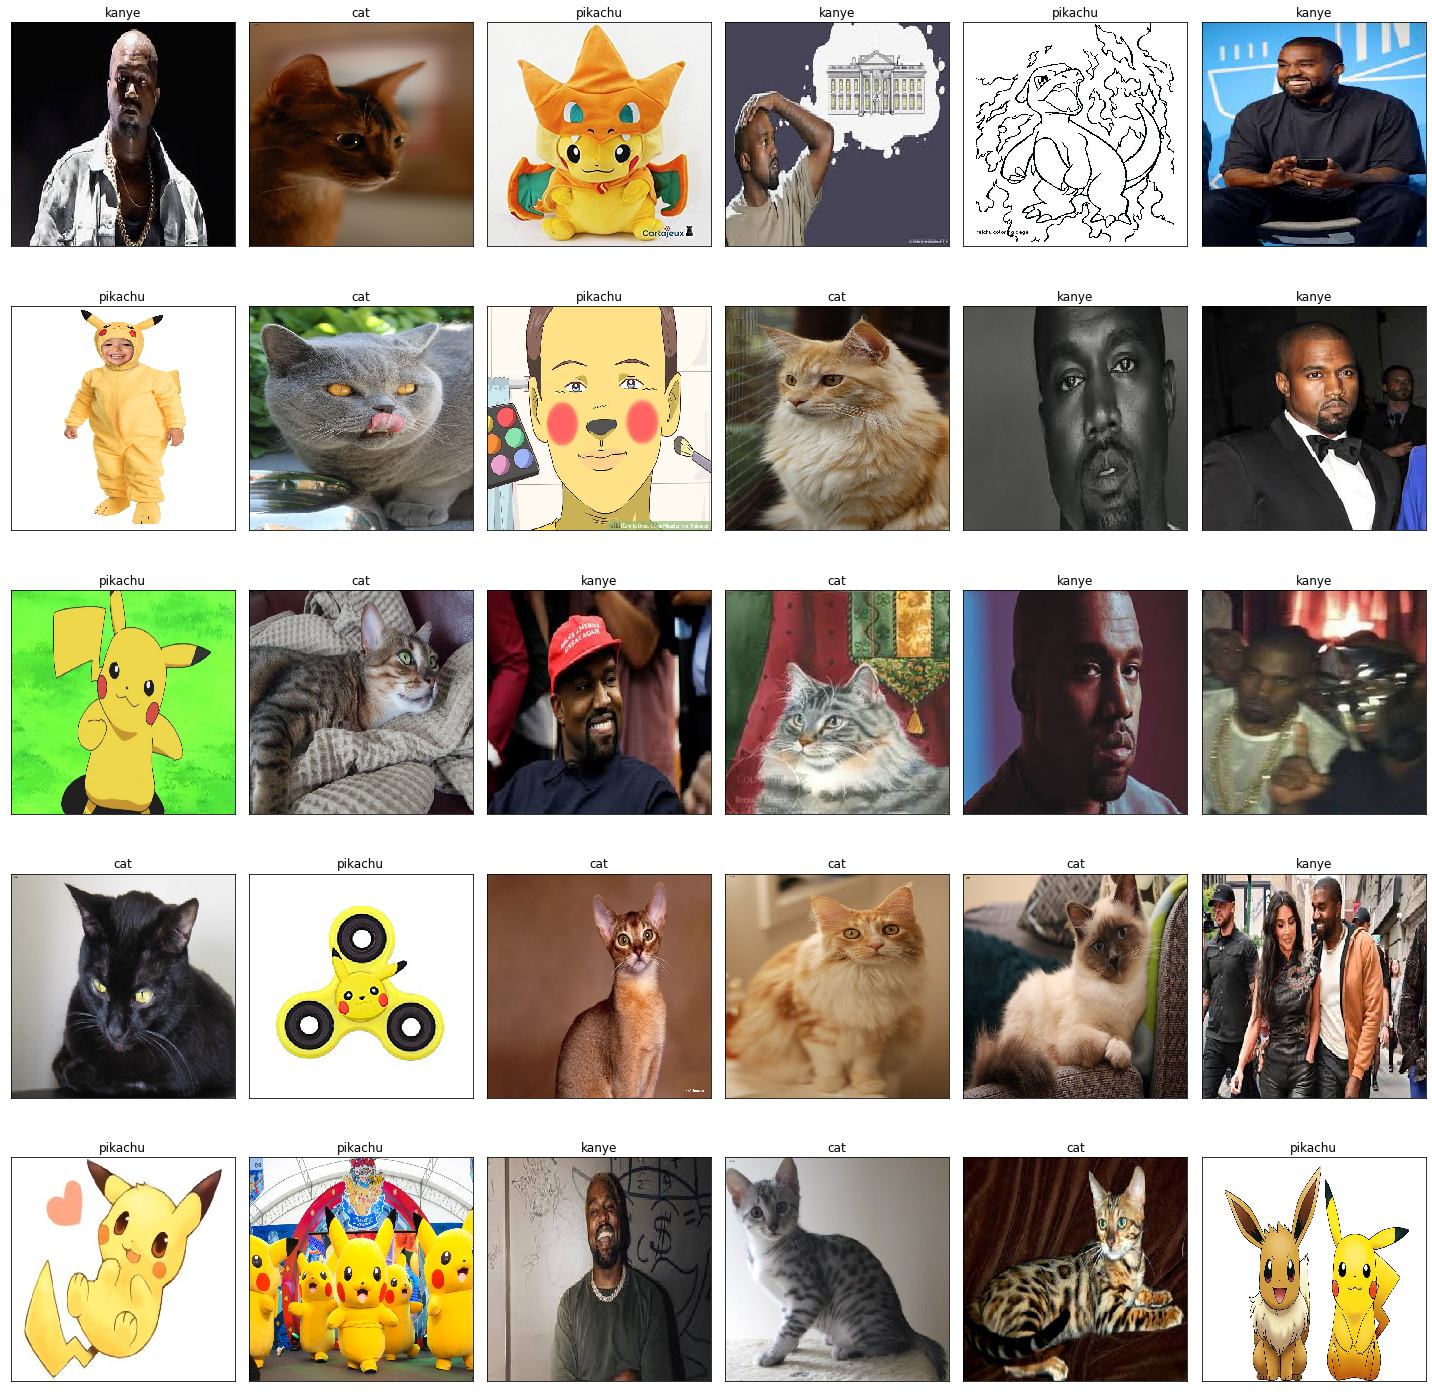

In [14]:
# create figure object
fig, axes = plt.subplots(5, 6, figsize = (20, 20))
for i, ax in enumerate(axes.flatten()):
  # choose random index
  index = np.random.choice(len(images_data))
    
  # display image and label
  ax.imshow(images_data[index] / 255.0)
  ax.set_title(LABELS[image_labels[index]])

  # make figure axes invisible
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.tight_layout()

## Split data into training, test and validation sets

In [15]:
# test split
x, x_test, y, y_test = train_test_split(np.array(images_data), 
                                        np.array(image_labels),
                                        test_size = 0.013,
                                        random_state = 42,
                                        stratify = np.array(image_labels))

# train and validation split
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size = 0.15,
                                                  random_state = 42,
                                                  stratify = y)

# print the shape of train, test and validation data sets
print(f'Shape of x_train: {x_train.shape}\nShape of y_train: {y_train.shape}')
print(f'Shape of x_test: {x_test.shape}\nShape of y_test: {y_test.shape}')
print(f'Shape of x_val: {x_val.shape}\nShape of y_val: {y_val.shape}')

Shape of x_train: (3230, 224, 224, 3)
Shape of y_train: (3230,)
Shape of x_test: (51, 224, 224, 3)
Shape of y_test: (51,)
Shape of x_val: (570, 224, 224, 3)
Shape of y_val: (570,)


## Load pretrained model

In [16]:
# EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (224, 224, 3))

# freeze the base model
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D(name = 'g_pool')(base_model.output)
x = tf.keras.layers.Dropout(0.3, name = 'drop_1')(x)
x = tf.keras.layers.Dense(32, activation = 'relu', name = 'dense_1')(x)
x = tf.keras.layers.Dropout(0.3, name = 'drop_2')(x)
output = tf.keras.layers.Dense(3, activation = 'softmax', name = 'output')(x)

model = tf.keras.Model(base_model.inputs, output, name = 'classification_model')
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "classification_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________

## Compile and fit the model

In [17]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


history = model.fit(x_train, y_train,
                    batch_size = 32,
                    epochs = 5,
                    validation_data = (x_val, y_val))

Epoch 1/5
101/101 [==============================] - 41s 64ms/step - loss: 0.4046 - accuracy: 0.8540 - val_loss: 0.0101 - val_accuracy: 0.9982
Epoch 2/5
101/101 [==============================] - 5s 50ms/step - loss: 0.0327 - accuracy: 0.9915 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/5
101/101 [==============================] - 5s 49ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 4/5
101/101 [==============================] - 5s 50ms/step - loss: 0.0118 - accuracy: 0.9977 - val_loss: 0.0038 - val_accuracy: 0.9982
Epoch 5/5
101/101 [==============================] - 5s 50ms/step - loss: 0.0147 - accuracy: 0.9970 - val_loss: 0.0038 - val_accuracy: 0.9982


## Plot training and validation loss and accuracy

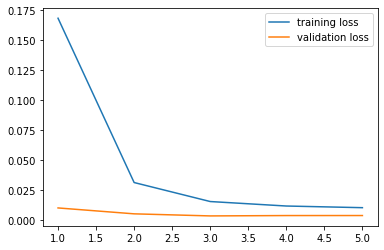

In [18]:
# training and validation loss
plt.plot(range(1, 6), history.history['loss'])
plt.plot(range(1, 6), history.history['val_loss'])
plt.legend(['training loss', 'validation loss']);

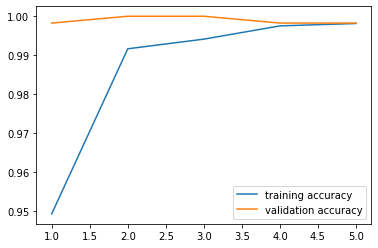

In [19]:
# training and validation accuracy
plt.plot(range(1, 6), history.history['accuracy'])
plt.plot(range(1, 6), history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy']);

## Evaluate the model performance on the test data

In [20]:
# calculate class probabilities
class_probs = model.predict(x_test)

# extract index with maximum probabilities
labels = np.argmax(class_probs, axis = -1)

# print class probabilities
print(class_probs)

[[9.99851108e-01 1.04546125e-04 4.43966492e-05]
 [1.38750802e-05 1.45287006e-04 9.99840856e-01]
 [9.99998212e-01 1.60083857e-06 2.19124516e-07]
 [6.62629134e-07 7.49990534e-07 9.99998569e-01]
 [9.99969125e-01 2.95863283e-05 1.36882522e-06]
 [3.36596372e-07 4.00929321e-06 9.99995708e-01]
 [2.43836621e-05 1.78718983e-04 9.99796927e-01]
 [9.99954581e-01 3.11382682e-05 1.42858489e-05]
 [8.70945094e-09 7.59866694e-08 9.99999881e-01]
 [1.80754313e-07 9.99999762e-01 2.40997577e-09]
 [6.44081581e-07 9.99999166e-01 2.15712291e-07]
 [9.95485842e-01 2.47807591e-03 2.03603343e-03]
 [3.12768716e-05 7.60576571e-04 9.99208152e-01]
 [2.50001222e-06 9.99996901e-01 5.44222587e-07]
 [5.57365183e-07 9.99999285e-01 8.69162733e-08]
 [1.01113378e-03 7.67641440e-02 9.22224760e-01]
 [9.99978185e-01 4.13721955e-06 1.75978512e-05]
 [9.99998569e-01 1.14282830e-06 2.02211183e-07]
 [9.99994159e-01 4.48611308e-06 1.31639035e-06]
 [9.99960899e-01 2.49432942e-05 1.41308856e-05]
 [9.12555720e-08 9.99998689e-01 1.205813

## Display test results

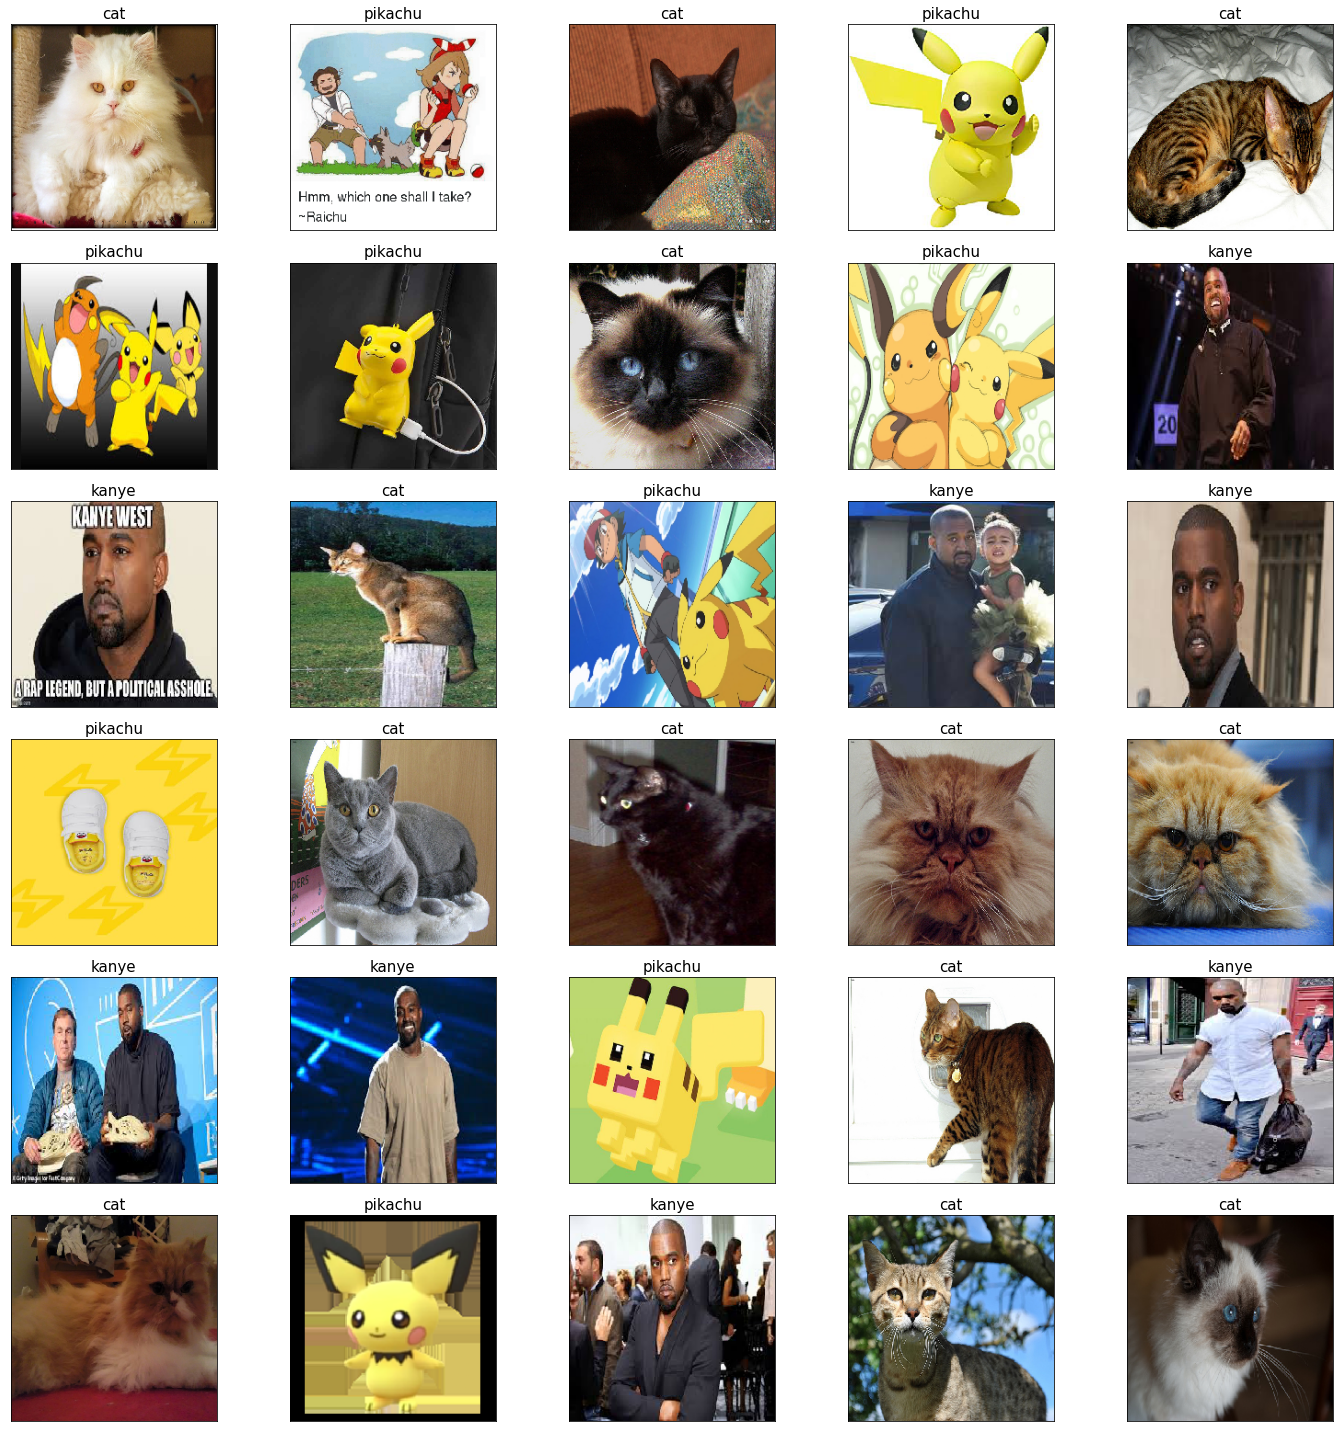

In [31]:
# first 20 examples
fig, axis = plt.subplots(6, 5, figsize = (20, 20))
for i, ax in enumerate(axis.flatten()):
  # show image and predicted label
  ax.imshow(x_test[i] / 255)
  ax.set_title(LABELS[labels[i]], fontsize = 15)
  # make figure axes invisible
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.tight_layout()

### next 20 examples

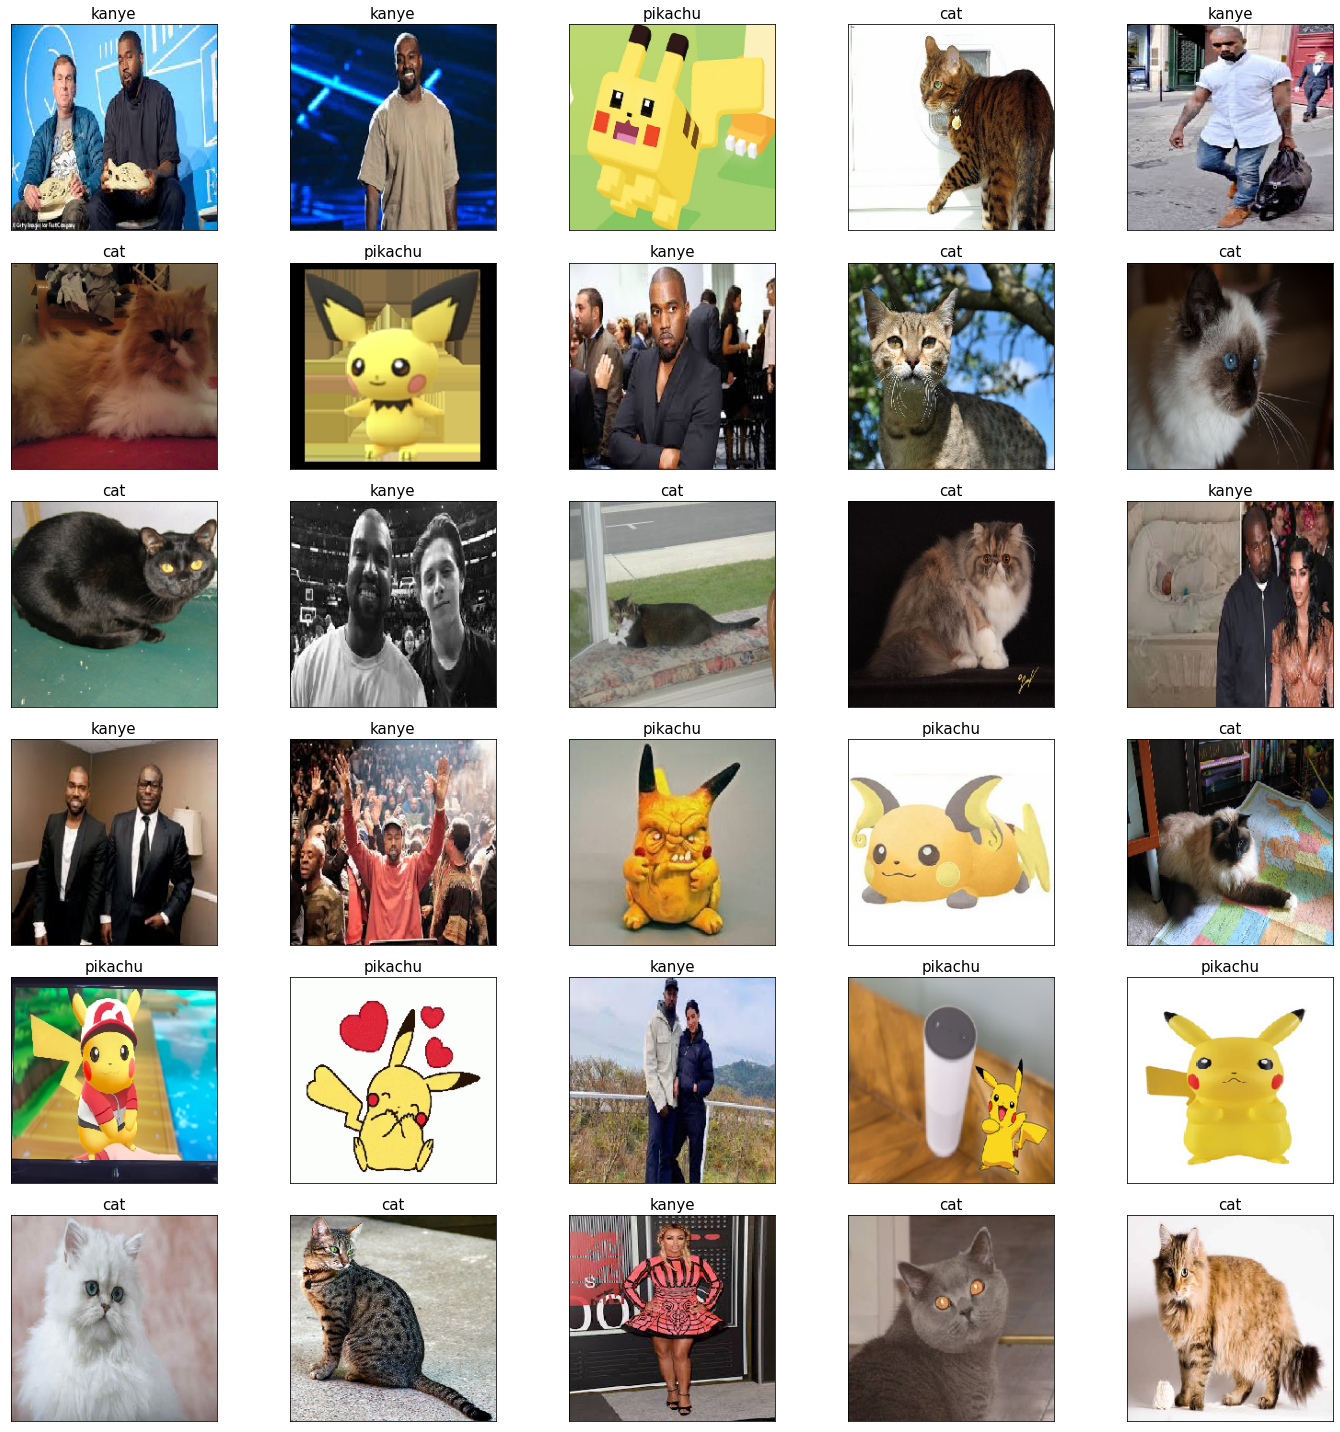

In [32]:
fig, axis = plt.subplots(6, 5, figsize = (20, 20))
for i, ax in enumerate(axis.flatten()):
  # show image and predicted label
  ax.imshow(x_test[i + 20] / 255)
  ax.set_title(LABELS[labels[i + 20]], fontsize = 15)
  # make figure axes invisible
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.tight_layout()

### Plot confusion matrix 

In [41]:
# evaluate model on validation data
y_pred = np.argmax(model.predict(x_val), axis = -1)

# plot confusion matrix
confusion_matrix(y_val, y_pred, labels = [0, 1, 2])

array([[237,   0,   0],
       [  0, 156,   1],
       [  0,   0, 176]])

# Part 2

In [43]:
# Read data from text files
ny = pd.read_csv('/content/ny.txt', sep = '\t')
google = pd.read_csv('/content/google.txt', sep = '\t')
yahoo = pd.read_csv('/content/yahoo.txt', sep = '\t')

In [46]:
# display the head of the datasets
print(ny.head())
print('\n')
print(google.head())
print('\n')
print(yahoo.head())

   Modified Julian Date  Max Temperature
0                 48988               52
1                 49019               38
2                 49047               31
3                 49078               66
4                 49108               75


   Modified Julian Date  Stock Value
0                 55463       527.21
1                 55462       513.48
2                 55461       516.00
3                 55460       513.46
4                 55459       508.28


   Modified Julian Date  Stock Value
0                 55463        14.40
1                 55462        14.17
2                 55461        14.04
3                 55460        14.18
4                 55459        13.86


## Plot the datasets

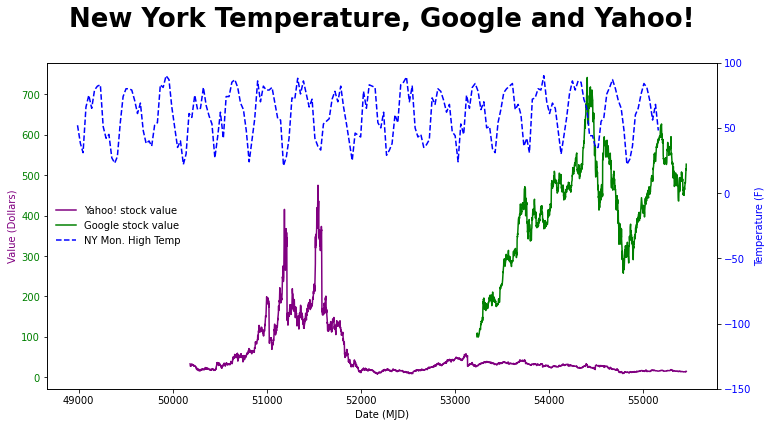

In [48]:
fig, ax1 = plt.subplots(figsize = (12, 6))  
ax1.set_title('New York Temperature, Google and Yahoo!\n', 
              fontweight = 'bold', 
              fontsize = 26)

ax1.set_xlabel('Date (MJD)')  
ax1.set_ylabel('Value (Dollars)', color = 'purple')  
plot_1 = ax1.plot(yahoo['Modified Julian Date'], 
               yahoo['Stock Value'], 
               color = 'purple', 
               label = 'Yahoo! stock value')  
ax1.tick_params(axis = 'y', labelcolor = 'green')  

plot_2 = ax1.plot(google['Modified Julian Date'], 
               google['Stock Value'], 
               color = 'green',
               label = 'Google stock value') 

ax2 = ax1.twinx()  
ax2.set_ylabel('Temperature (F)', color = 'blue')  
plot_3 = ax2.plot(ny['Modified Julian Date'],
               ny['Max Temperature'], 'b--',
               label = 'NY Mon. High Temp')  
ax2.tick_params(axis = 'y', labelcolor = 'blue')


ax2.set_ylim([-150, 100])
plot = plot_1 + plot_2 + plot_3
labels = [label.get_label() for label in plot]
ax1.legend(plot, labels, loc = 6, frameon = False);